In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np

class logistic:
  def __init__(self, weights, bias, epochs, learning_rate, tolerance, activation='sigmoid'):
    self.weights = weights
    self.bias = bias
    self.epochs = epochs
    self.learning_rate = learning_rate
    self.tolerance = tolerance
    self.activation = activation
    self.cost_history = {
      'sigmoid': [],
      'tanh': [],
      'relu': [],
      'swish': []
    }

  def cross_entropy_loss(self, y, y_hat):
    loss = 0
    for i in range(len(y)):
      # Add small epsilon to avoid log(0)
      epsilon = 1e-15
      y_hat[i] = max(min(y_hat[i], 1 - epsilon), epsilon)
      loss += -y[i] * math.log(y_hat[i]) - (1 - y[i]) * math.log(1 - y_hat[i])
    return loss / len(y)

  def activation_function(self, z, activation_type):
    if activation_type == 'sigmoid':
      # Clip z to avoid overflow in exp
      z = min(max(z, -100), 100)
      return 1 / (1 + math.exp(-z))
    elif activation_type == 'tanh':
      # Clip z to avoid overflow in exp
      z = min(max(z, -100), 100)
      return (math.exp(z) - math.exp(-z)) / (math.exp(z) + math.exp(-z))
    elif activation_type == 'relu':
      return max(0, z)
    elif activation_type == 'swish':
      # Clip z to avoid overflow in exp
      z = min(max(z, -100), 100)
      return z / (1 + math.exp(-z))
    else:
      raise ValueError(f"Unsupported activation function: {activation_type}")

  def activation_derivative(self, z, activation_type):
    if activation_type == 'sigmoid':
      sig = self.activation_function(z, 'sigmoid')
      return sig * (1 - sig)
    elif activation_type == 'tanh':
      tanh_z = self.activation_function(z, 'tanh')
      return 1 - tanh_z ** 2
    elif activation_type == 'relu':
      return 1 if z > 0 else 0
    elif activation_type == 'swish':
      sig = self.activation_function(z, 'sigmoid')
      return sig + z * sig * (1 - sig)
    else:
      raise ValueError(f"Unsupported activation function: {activation_type}")

  def normalize_activation(self, value, activation_type):
    """Normalize activation output to [0,1] range for binary classification"""
    if activation_type == 'sigmoid':
      return value  # Already in [0,1]
    elif activation_type == 'tanh':
      return (value + 1) / 2  # Convert from [-1,1] to [0,1]
    elif activation_type == 'relu':
      return min(1, max(0, value))  # Clip to [0,1]
    elif activation_type == 'swish':
      return min(1, max(0, value))  # Clip to [0,1]
    else:
      raise ValueError(f"Unsupported activation function: {activation_type}")

  def compute_y_hat(self, x, activation_type):
    z = sum(x[i]*self.weights[i] for i in range(len(self.weights))) + self.bias
    activated = self.activation_function(z, activation_type)
    return self.normalize_activation(activated, activation_type)

  def compute_gradient(self, X, y, activation_type):
    n_samples = len(X)
    n_features = len(X[0])
    dw = [0] * n_features
    db = 0

    for j in range(n_samples):
      z = sum(X[j][i]*self.weights[i] for i in range(len(self.weights))) + self.bias
      y_pred = self.normalize_activation(self.activation_function(z, activation_type), activation_type)

      # Compute error and apply chain rule with activation derivative
      error = y_pred - y[j]

      for i in range(n_features):
        dw[i] += error * X[j][i] * self.activation_derivative(z, activation_type)
      db += error * self.activation_derivative(z, activation_type)

    dw = [dw_i / n_samples for dw_i in dw]
    db /= n_samples

    return dw, db

  def descent(self, dw, db):
    for i in range(len(self.weights)):
      self.weights[i] -= self.learning_rate * dw[i]
    self.bias -= self.learning_rate * db

  def fit(self, X, y, compare_activations=False):
    activation_functions = ['sigmoid', 'tanh', 'relu', 'swish'] if compare_activations else [self.activation]
    results = {}

    # Save initial weights and bias
    initial_weights = self.weights.copy()
    initial_bias = self.bias

    for activation_type in activation_functions:
      # Reset weights and bias to initial values for fair comparison
      self.weights = initial_weights.copy()
      self.bias = initial_bias
      self.cost_history[activation_type] = []

      prev_loss = float('inf')
      for epoch in range(self.epochs):
        y_hat = [self.compute_y_hat(X[i], activation_type) for i in range(len(X))]
        loss = self.cross_entropy_loss(y, y_hat)

        self.cost_history[activation_type].append(loss)

        dw, db = self.compute_gradient(X, y, activation_type)
        self.descent(dw, db)

        if abs(prev_loss - loss) < self.tolerance:
          print(f"Converged at epoch {epoch+1} using {activation_type} activation")
          break

        prev_loss = loss

      # Store final weights and bias for this activation function
      results[activation_type] = {
        'weights': self.weights.copy(),
        'bias': self.bias
      }

    # Restore weights to the selected activation if comparing
    if compare_activations:
      self.weights = results[self.activation]['weights']
      self.bias = results[self.activation]['bias']

    return results if compare_activations else None

  def predict(self, X):
    return [self.compute_y_hat(x, self.activation) for x in X]

  def visualize_cost(self, activation_functions=None):
    """Visualize how different activation functions change cross-entropy loss over epochs."""
    if activation_functions is None:
      activation_functions = [self.activation]

    plt.figure(figsize=(14, 8))

    for activation_type in activation_functions:
      if len(self.cost_history[activation_type]) > 0:
        plt.plot(
          range(1, len(self.cost_history[activation_type]) + 1),
          self.cost_history[activation_type],
          marker='o' if len(self.cost_history[activation_type]) < 50 else None,
          linestyle='-',
          label=f'{activation_type.title()} Activation'
        )

    plt.title('Cross-Entropy Loss with Different Activation Functions')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Use log scale if values have high range
    if any(self.cost_history[act][0] > 10*self.cost_history[act][-1]
           for act in activation_functions if len(self.cost_history[act]) > 0):
      plt.yscale('log')

    # Add annotations for initial and final costs
    for activation_type in activation_functions:
      history = self.cost_history[activation_type]
      if len(history) > 0:
        plt.annotate(
          f'Initial {activation_type}: {history[0]:.4f}',
          xy=(1, history[0]),
          xytext=(len(history)//10, history[0] * 1.1),
          arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8)
        )

        plt.annotate(
          f'Final {activation_type}: {history[-1]:.4f}',
          xy=(len(history), history[-1]),
          xytext=(len(history) - len(history)//5, history[-1] * 1.1),
          arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8)
        )

    plt.show()

  def visualize_activation_functions(self):
    """Plot the activation functions in the range [-5, 5]."""
    x = np.linspace(-5, 5, 1000)

    plt.figure(figsize=(14, 8))

    activations = {
      'sigmoid': [self.activation_function(z, 'sigmoid') for z in x],
      'tanh': [self.activation_function(z, 'tanh') for z in x],
      'relu': [self.activation_function(z, 'relu') for z in x],
      'swish': [self.activation_function(z, 'swish') for z in x]
    }

    for act_name, act_values in activations.items():
      plt.plot(x, act_values, label=f'{act_name.title()}')

    plt.title('Activation Functions Comparison')
    plt.xlabel('Input (z)')
    plt.ylabel('Output')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.show()

  def compare_activation_functions(self, X, y):
    """Train using all activation functions and visualize their comparison."""
    # Visualize the activation functions
    self.visualize_activation_functions()

    # Train with all activation functions
    self.fit(X, y, compare_activations=True)

    # Visualize cross-entropy loss for all activation functions
    self.visualize_cost(['sigmoid', 'tanh', 'relu', 'swish'])

    # Print final statistics
    print("\nCross-Entropy Loss with Different Activation Functions:")
    for activation_type in ['sigmoid', 'tanh', 'relu', 'swish']:
      history = self.cost_history[activation_type]
      if len(history) > 0:
        print(f"{activation_type.title()} Activation:")
        print(f"  Initial Cost: {history[0]:.6f}")
        print(f"  Final Cost: {history[-1]:.6f}")
        print(f"  Improvement: {(1 - history[-1]/history[0])*100:.2f}%")
        print(f"  Convergence: {len(history)} epochs")
        print()

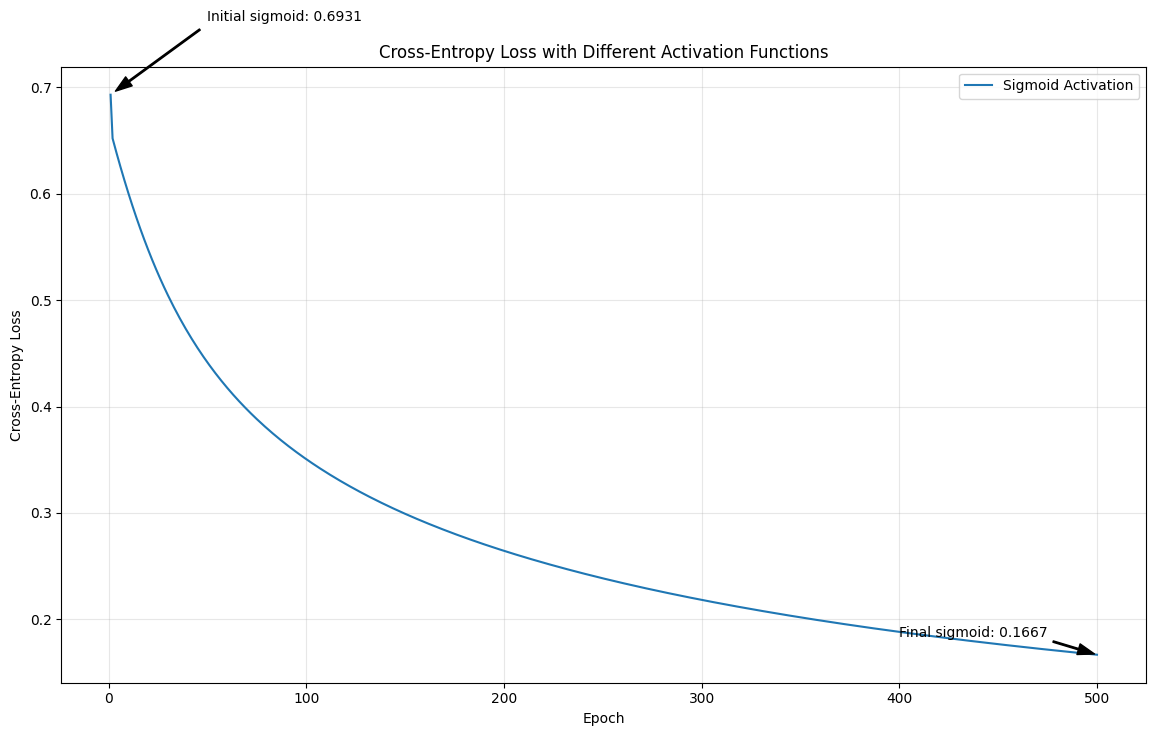

In [3]:
X = [
    [1.2, 2.3], [1.5, 2.1], [1.7, 1.9], [1.9, 2.2], [2.1, 1.8],
    [2.0, 2.5], [1.8, 2.7], [1.6, 2.9], [1.4, 2.8], [2.2, 2.0],
    [3.2, 3.5], [3.5, 3.1], [3.7, 3.2], [3.9, 3.6], [4.1, 3.8],
    [4.0, 3.4], [3.8, 3.7], [3.6, 3.9], [3.4, 4.1], [4.2, 3.3]
]
y = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
model = logistic(weights=[0, 0], bias=0, epochs=500, learning_rate=0.8, tolerance=1e-4)
model.fit(X, y)
model.visualize_cost()


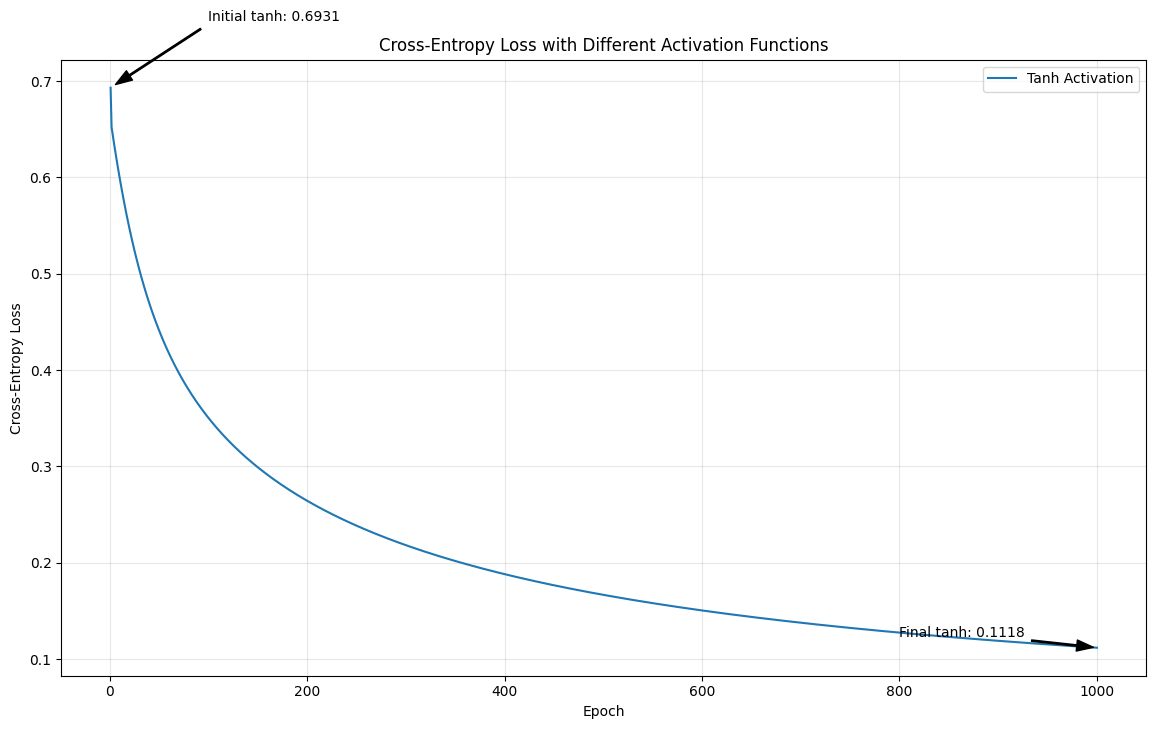

In [4]:
model = logistic([0.0, 0.0], 0.0, 1000, 0.1, 1e-5, activation='tanh')
model.fit(X, y)
predictions = model.predict(X)
model.visualize_cost()

[0]


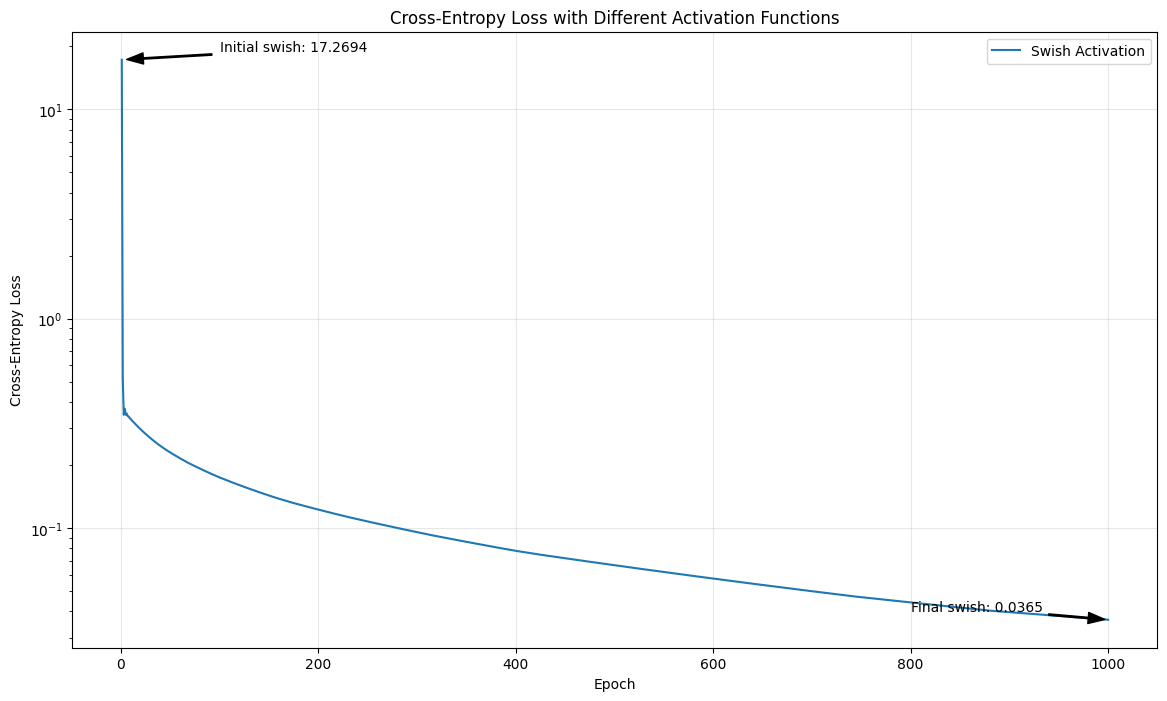

In [13]:
model = logistic([0.0, 0.0], 0.0, 1000, 0.1, 1e-5, activation='swish')
model.fit(X, y)
print(model.predict([[1.2,2.3]]))
model.visualize_cost()
#

Converged at epoch 2 using relu activation


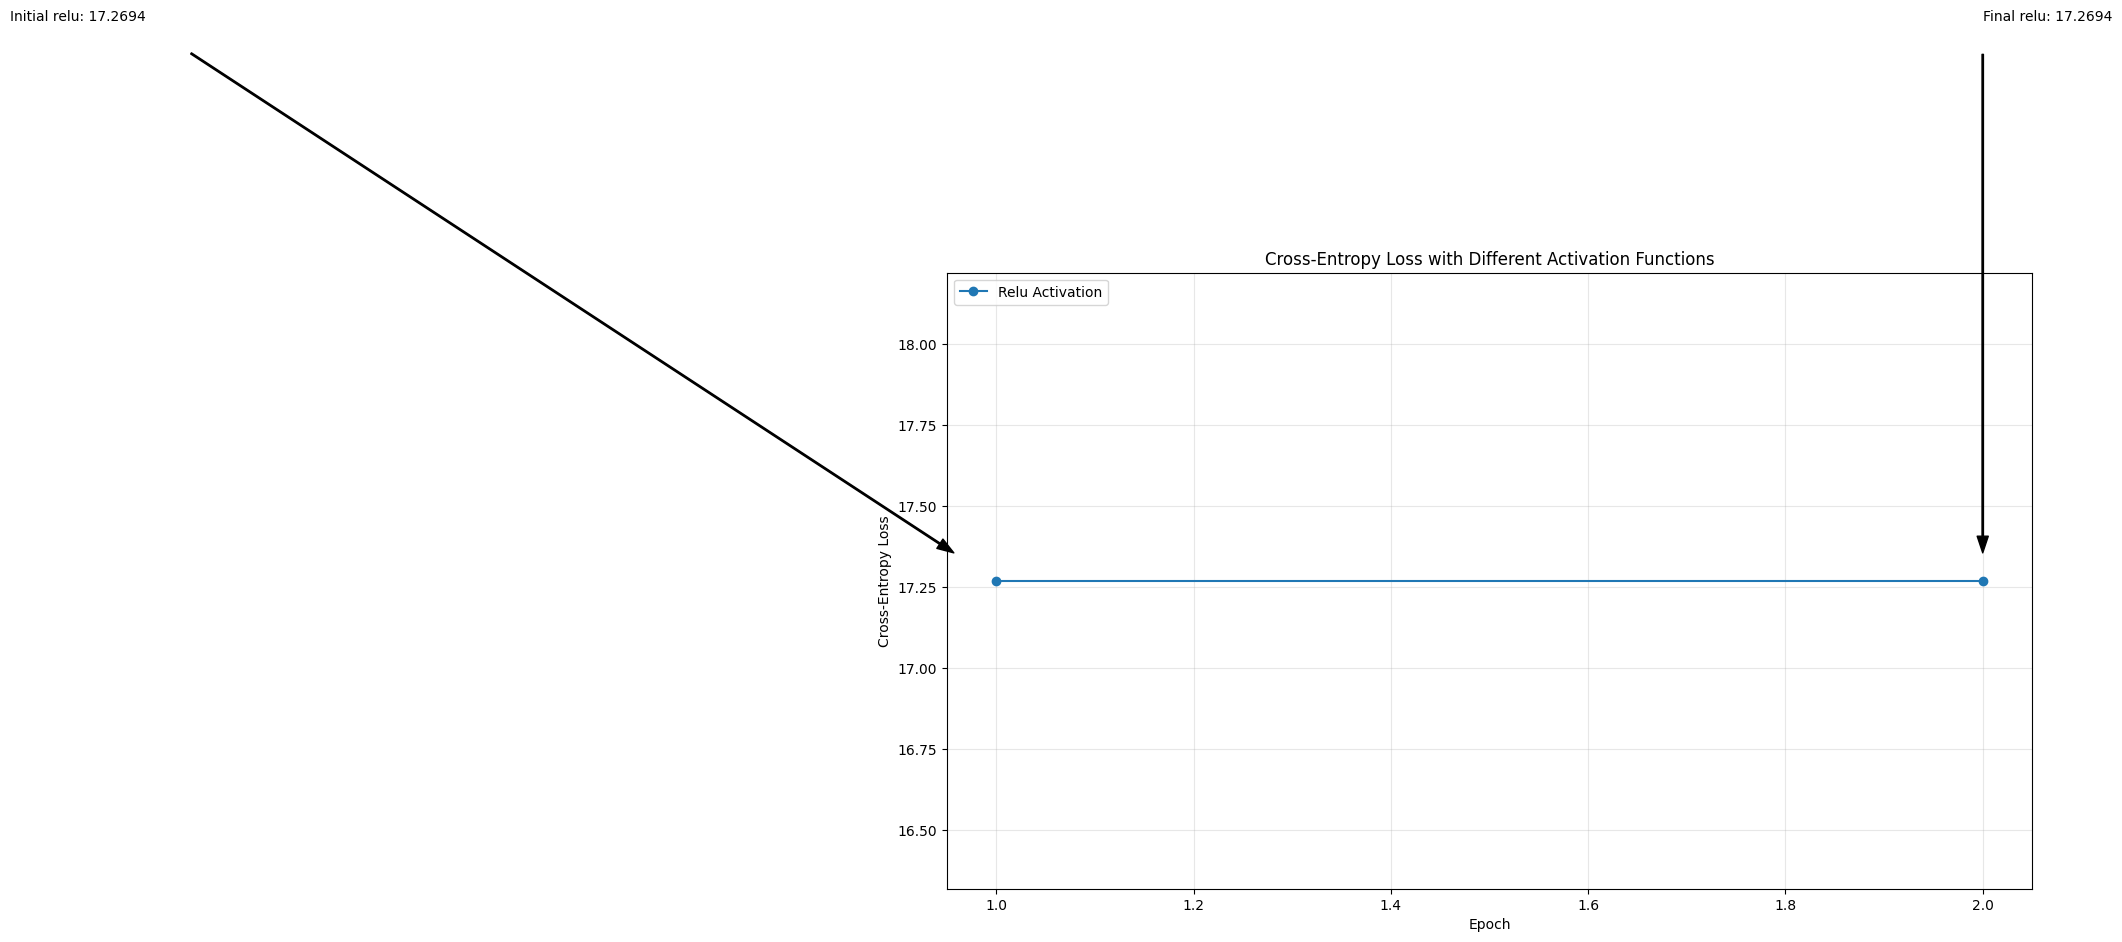

In [6]:
model = logistic([0.0, 0.0], 0.0, 1000, 0.1, 1e-5, activation='relu')
model.fit(X, y)
predictions = model.predict(X)
model.visualize_cost()
#wtf, lol

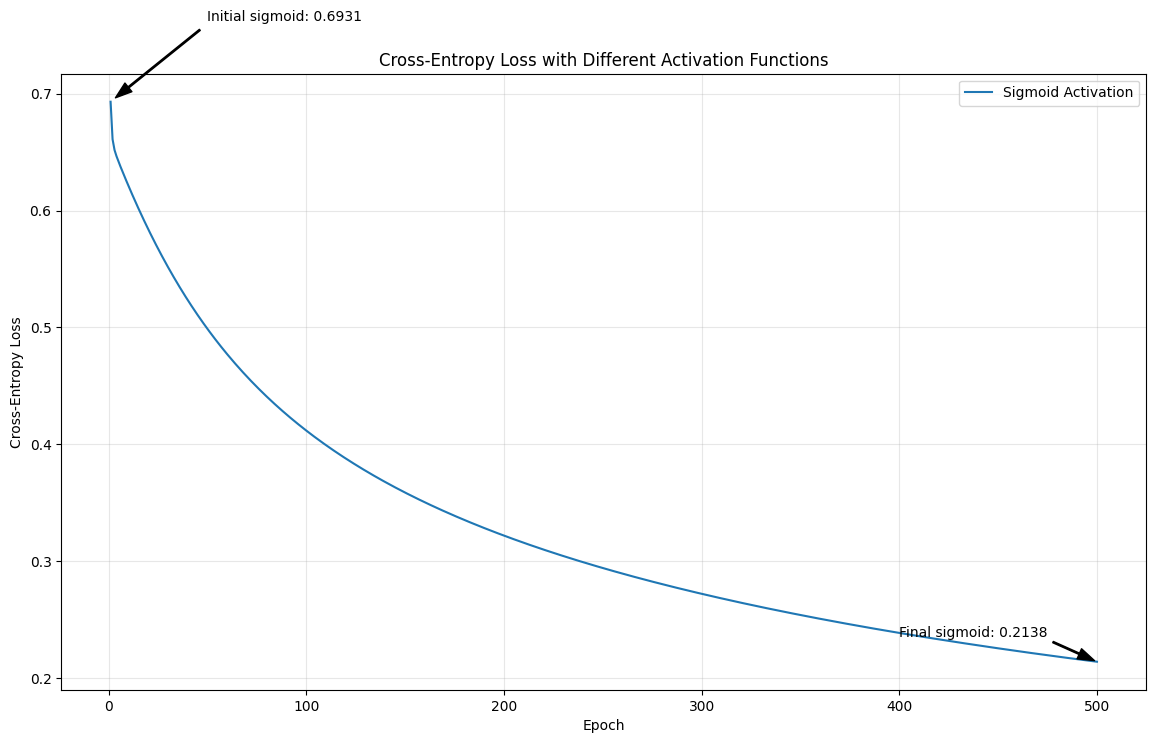

In [7]:
model = logistic(weights=[0, 0], bias=0, epochs=500, learning_rate=0.5, tolerance=1e-4)
model.fit(X, y)
model.visualize_cost()

Converged at epoch 173 using swish activation


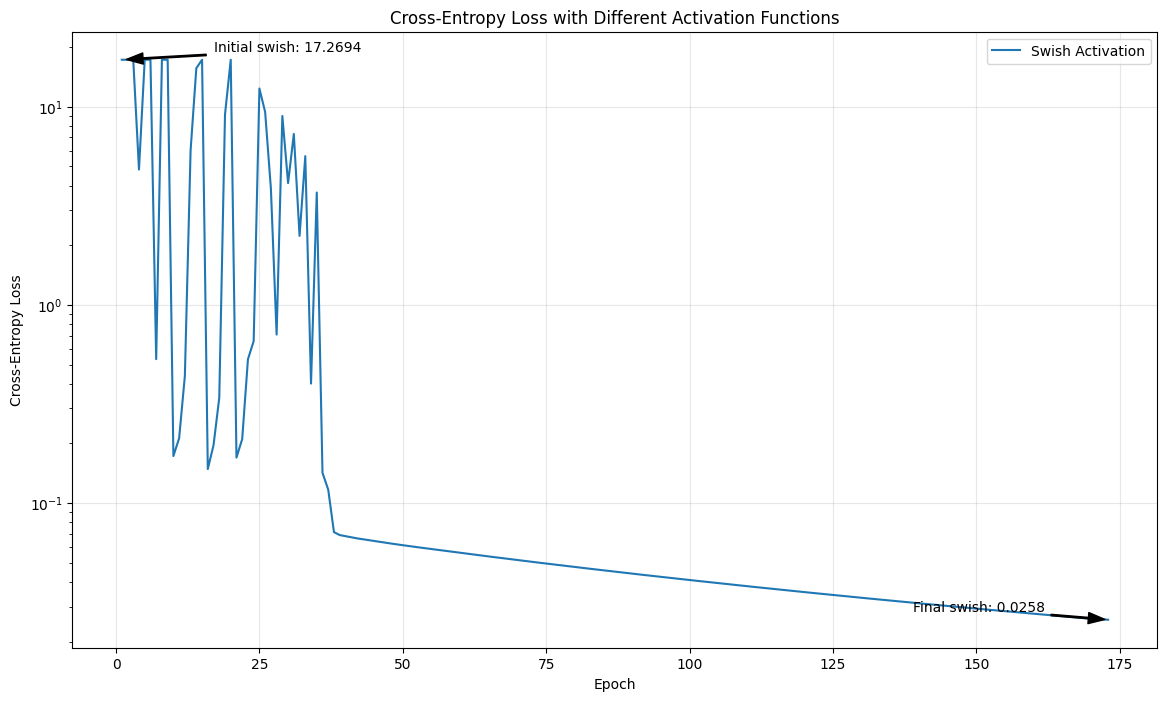

In [8]:
model = logistic(weights=[0, 0], bias=0, epochs=500, learning_rate=0.5, tolerance=1e-4,activation='swish')
model.fit(X, y)
model.visualize_cost()


Converged at epoch 95 using tanh activation


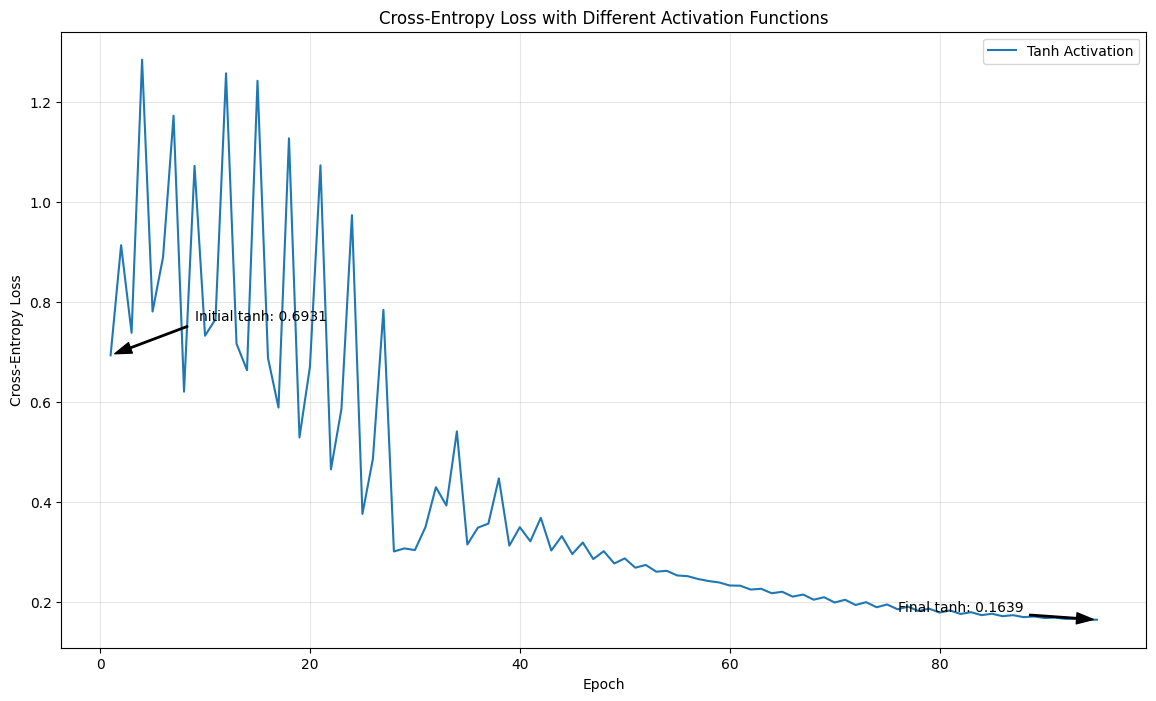

In [10]:
model = logistic(weights=[0, 0], bias=0, epochs=500, learning_rate=0.5, tolerance=1e-4,activation='tanh')
model.fit(X, y)
model.visualize_cost()
#higher learning rates dont work for swish but swish outperforms sigmoid and tanh at learning rate 0.5

In [ ]:
model = logistic(weights=[0, 0], bias=0, epochs=500, learning_rate=1.5, tolerance=1e-4)
model.fit(X, y)
model.visualize_cost()